<h1>
<hr style=" border:none; height:3px;">
<center>Evaluation workflow</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Camille DURANTON</center></h4>

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simulation import FleetSimulation
from robot import Fleet, si_to_uni
import pandas as pd
import control_algo_potential
import seaborn as sns

# Simulations

In [2]:
def run_simulation(nbOfRobots=5, target_potential=313, margin_target_potential=3):
    time_to_reach = [float('inf') for _ in range(nbOfRobots)]
    fleet = Fleet(nbOfRobots, dynamics='singleIntegrator2D')
    for i in range(nbOfRobots):
        fleet.robot[i].state = 20 * np.random.rand(2) - 10

    Te = 1
    simulation = FleetSimulation(fleet, t0=0.0, tf=20.0, dt=Te)

    dummy_vx, dummy_vy, pot = control_algo_potential.potential_seeking_ctrl(0, 0, fleet.getPosesArray())

    potential_history = [[] for _ in range(nbOfRobots)]
    init_poses = fleet.getPosesArray().copy()
    initial_potentials = [pot.value(np.array([init_poses[r, :]])) for r in range(nbOfRobots)]
    for r in range(nbOfRobots):
        potential_history[r].append(initial_potentials[r])

    for t in simulation.t:
        robots_poses = fleet.getPosesArray()
        for r in range(nbOfRobots):
            vx, vy, pot = control_algo_potential.potential_seeking_ctrl(t, r, robots_poses)
            fleet.robot[r].ctrl = np.array([vx, vy])
        simulation.addDataFromFleet(fleet)
        fleet.integrateMotion(Te)
        robots_poses = fleet.getPosesArray()
        if abs(t - round(t)) < Te/2:
            for r in range(nbOfRobots):
                potential_history[r].append(pot.value(np.array([robots_poses[r, :]])))
                if abs(potential_history[r][-1] - target_potential) < margin_target_potential and time_to_reach[r] == float('inf'):
                    time_to_reach[r] = t

    return potential_history, time_to_reach

In [3]:
potential_history, time_to_reach = run_simulation(8)
print(time_to_reach)
print(potential_history[5][-1])

[2.0, 2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 2.0]
313.09328333823856


In [4]:
def evaluate_robots(nb_trials=3, nbOfRobots=8, target_potential=313, margin_target_potential=2):
    results = []
    for trial in range(nb_trials):
        potential_history, time_to_reach = run_simulation(nbOfRobots=nbOfRobots,
                                                          target_potential=target_potential,
                                                          margin_target_potential=margin_target_potential)
        for r in range(nbOfRobots):
            results.append({
                'trial': trial,
                'robot': r+1,
                'initial_potential': potential_history[r][0],
                'reached_potential': potential_history[r][-1],
                'pollution_center_reached': (abs(potential_history[r][-1] - target_potential) < margin_target_potential).astype(int),
                'time_to_reach': time_to_reach[r],
                'reached_at_5sec': time_to_reach[r] <= 5.0
            })
    df = pd.DataFrame(results)
    return df

# Post processing

In [159]:
df_results = evaluate_robots(nb_trials=30)
print(df_results.head())

   trial  robot  initial_potential  reached_potential  \
0      0      1         300.672345         299.794322   
1      0      2         295.343373         306.048328   
2      0      3         309.368394         313.093248   
3      0      4         257.166710         305.461398   
4      0      5         300.118442         296.404361   

   pollution_center_reached  time_to_reach  reached_at_5sec  
0                         0            inf            False  
1                         0            inf            False  
2                         1            0.0             True  
3                         0            inf            False  
4                         0            inf            False  


In [160]:
summary = df_results.groupby('trial').agg(
    avg_time_to_reach=('time_to_reach', 'mean'),
    accuracy_at_5sec=('reached_at_5sec', 'mean')
).reset_index()
print("\nSummary Statistics:")
print(summary)


Summary Statistics:
    trial  avg_time_to_reach  accuracy_at_5sec
0       0                inf             0.500
1       1                inf             0.750
2       2                inf             0.750
3       3                inf             0.750
4       4                inf             0.875
5       5                inf             0.750
6       6              2.125             0.875
7       7                inf             0.625
8       8                inf             0.500
9       9                inf             0.875
10     10                inf             0.750
11     11                inf             0.750
12     12              3.875             0.750
13     13                inf             0.750
14     14                inf             0.500
15     15              3.000             0.875
16     16                inf             0.375
17     17                inf             0.625
18     18                inf             0.625
19     19                inf           

# Visualisation of results

## Batch visualization

C:\Users\Louis\AppData\Local\Temp\ipykernel_16488\1489068883.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y='time_to_reach', data=df_results, inner=None, palette='Blues', ax=ax, linewidth=1.5)


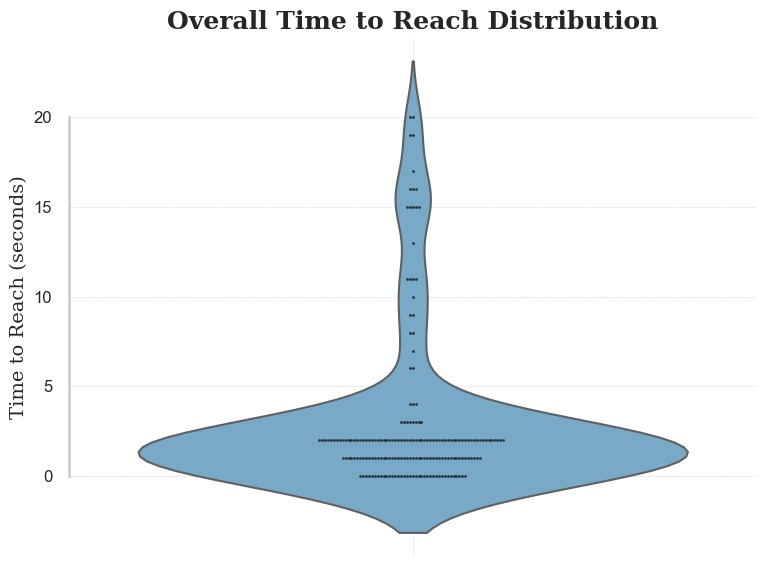

In [ ]:
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(y='time_to_reach', data=df_results, inner=None, palette='Blues', ax=ax, linewidth=1.5)
sns.swarmplot(y='time_to_reach', data=df_results, color='black', alpha=0.7, ax=ax, size=2)
ax.set_title('Overall Time to Reach Distribution', fontsize=18, fontweight='bold', fontname='serif')
ax.set_ylabel('Time to Reach (seconds)', fontsize=14, fontname='serif')
ax.set_xlabel('')
sns.despine(trim=True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


C:\Users\Louis\AppData\Local\Temp\ipykernel_16488\1093493417.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y='reached_at_5sec', data=df_results, inner=None, palette='Set3', ax=ax)
c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 19.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 24.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


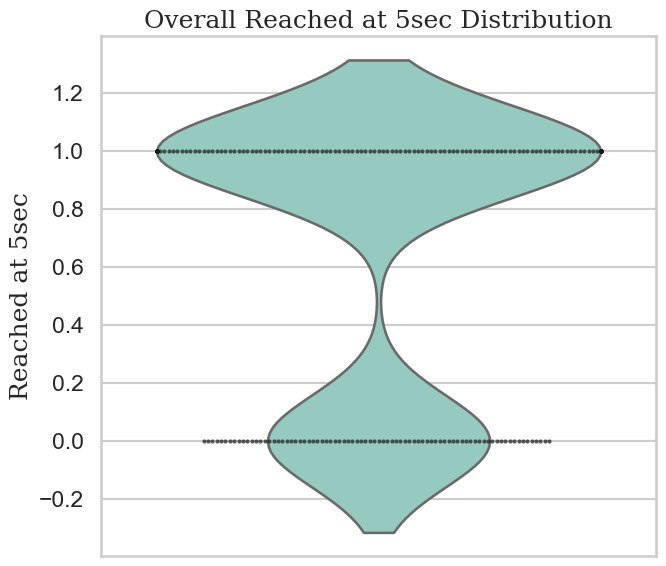

In [175]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.violinplot(y='reached_at_5sec', data=df_results, inner=None, palette='Set3', ax=ax)
sns.swarmplot(y='reached_at_5sec', data=df_results, color='k', alpha=0.7, ax=ax, size=3)
ax.set_title('Overall Reached at 5sec Distribution', fontname='serif')
ax.set_ylabel('Reached at 5sec', fontname='serif')

plt.tight_layout()
plt.show()

## Per trial

C:\Users\Louis\AppData\Local\Temp\ipykernel_16488\2305230550.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='trial', y='time_to_reach', data=df_results, ax=axes[0], inner=None, palette='Set2')
c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Louis\AppData\Local\Temp\ipykernel_16488\2305230550.py:4: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='trial', y='avg_time_to_reach', data=summary, ax=axes[0],
C:\Users\Louis\AppData\Local\Temp\ipy

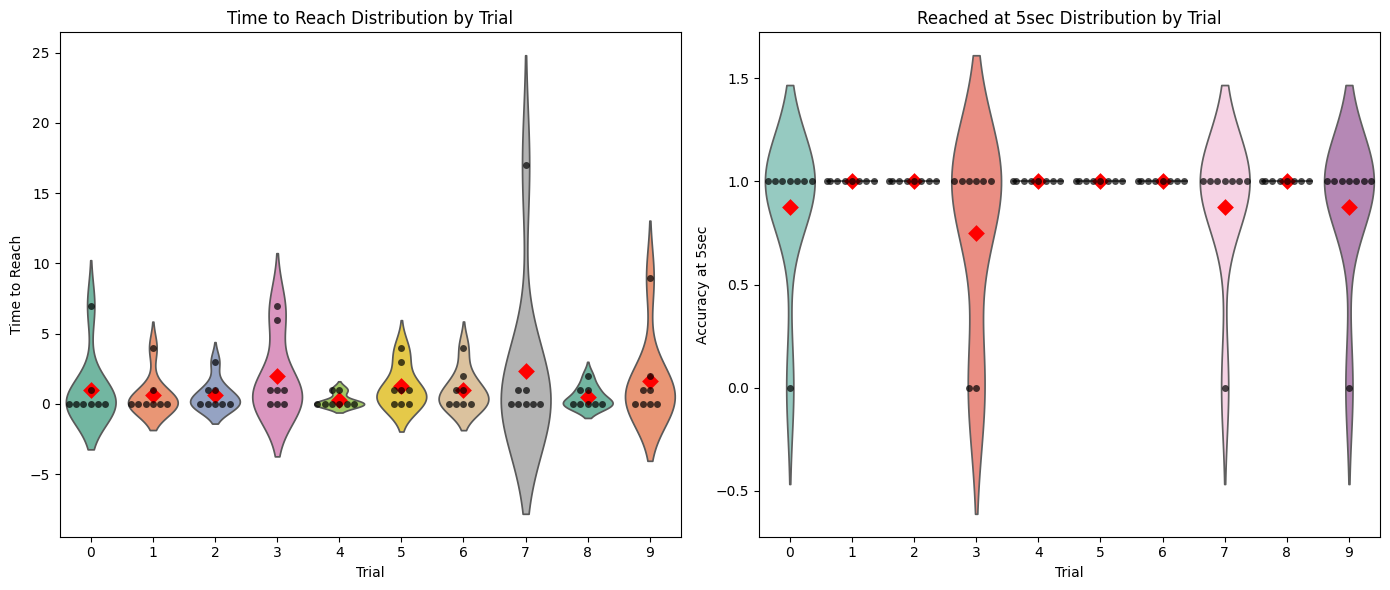

In [145]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.violinplot(x='trial', y='time_to_reach', data=df_results, ax=axes[0], inner=None, palette='Set2')
sns.swarmplot(x='trial', y='time_to_reach', data=df_results, ax=axes[0], color='k', alpha=0.7)
sns.pointplot(x='trial', y='avg_time_to_reach', data=summary, ax=axes[0],
              color='red', markers='D', linestyles='', scale=1.2, errwidth=0)
axes[0].set_title('Time to Reach Distribution by Trial')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Time to Reach')

# Violin plot for reached_at_5sec
sns.violinplot(x='trial', y='reached_at_5sec', data=df_results, ax=axes[1], inner=None, palette='Set3')
sns.swarmplot(x='trial', y='reached_at_5sec', data=df_results, ax=axes[1], color='k', alpha=0.7)
sns.pointplot(x='trial', y='accuracy_at_5sec', data=summary, ax=axes[1],
              color='red', markers='D', linestyles='', scale=1.2, errwidth=0)
axes[1].set_title('Reached at 5sec Distribution by Trial')
axes[1].set_xlabel('Trial')
axes[1].set_ylabel('Accuracy at 5sec')

plt.tight_layout()
plt.show()

C:\Users\Louis\AppData\Local\Temp\ipykernel_16488\2701015738.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='trial', y='time_to_reach', data=df_results, ax=axes[0], palette='Set2')
C:\Users\Louis\AppData\Local\Temp\ipykernel_16488\2701015738.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='trial', y='reached_at_5sec', data=df_results, ax=axes[1], palette='Set3')


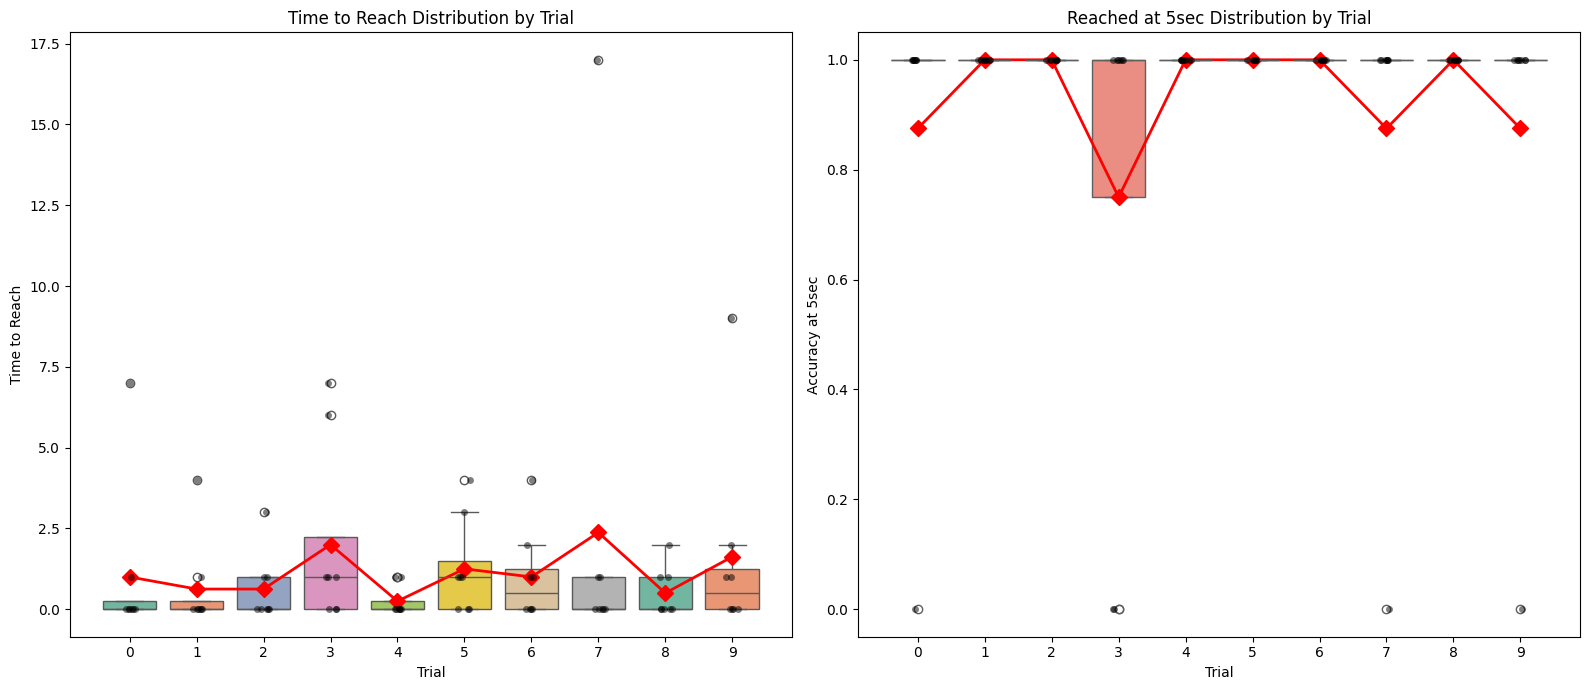

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Time to Reach visualization
sns.boxplot(x='trial', y='time_to_reach', data=df_results, ax=axes[0], palette='Set2')
sns.stripplot(x='trial', y='time_to_reach', data=df_results, ax=axes[0], color='black', alpha=0.5, jitter=True)
axes[0].plot(summary['trial'], summary['avg_time_to_reach'], color='red', marker='D',
             linestyle='-', linewidth=2, markersize=8)
axes[0].set_title('Time to Reach Distribution by Trial')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Time to Reach')

# Reached at 5sec visualization
sns.boxplot(x='trial', y='reached_at_5sec', data=df_results, ax=axes[1], palette='Set3')
sns.stripplot(x='trial', y='reached_at_5sec', data=df_results, ax=axes[1], color='black', alpha=0.5, jitter=True)
axes[1].plot(summary['trial'], summary['accuracy_at_5sec'], color='red', marker='D',
             linestyle='-', linewidth=2, markersize=8)
axes[1].set_title('Reached at 5sec Distribution by Trial')
axes[1].set_xlabel('Trial')
axes[1].set_ylabel('Accuracy at 5sec')

plt.tight_layout()
plt.show()